In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelleme için gerekli kütüphaneler:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# --- RandomForestClassifier kaldırıldı ---
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression  # Sadece LİNEER Regresyon
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [3]:
# --- Dosya Yükleme ---
# BURAYA KENDİ YEREL DOSYA YOLUNUZU YAZIN
# file_name = "C:/Users/ulasdeneme/Downloads/CDC_Wastewater_Data_for_Influenza_A.csv"
# VEYA JUPYTER NOTEBOOK İLE AYNI KLASÖRDEYSE SADECE ADINI YAZIN:
file_name = "C:/Users/ulasdeneme/Downloads/CDC_Wastewater_Data_for_Influenza_A.csv"

df = pd.read_csv(file_name, low_memory=False)

print("Veri seti yüklendi. İlk 5 satır:")
print(df.head())

Veri seti yüklendi. İlk 5 satır:
   sewershed_id wwtp_jurisdiction county_fips counties_served  \
0          2407                al       01125      Tuscaloosa   
1          2167                wi       55127        Walworth   
2           488                il       17167        Sangamon   
3           434                il       17043         Du Page   
4            97                ca       06013    Contra Costa   

   population_served                         sample_id sample_collect_date  \
0              12278  05a02bd4d68420ea7e9c030e8ce7fd08          2025-06-08   
1              30000  09e73eabdeca41f149d08ede0d92bbf1          2024-08-12   
2             102000  0b751586bf4ed642b7d73402c69d58a1          2024-05-16   
3              59805  0e3eb697c96f9645c691e10631317c7c          2025-01-28   
4             487300  176c33eaf7e144d6d9e2b5a9870b08bd          2025-02-05   

                     sample_type   sample_matrix sample_location  ...  \
0  24-hr time-weighted composite  

In [5]:
print("--- Veri Temizliği ve Özellik Mühendisliğine Başlanıyor ---")

# --- BİRİNCİ BÖLÜM: TEMİZLİK VE MÜHENDSLİK (%45) ---

# ZAMAN BAZLI ÖZELLİKLERİ ÇIKARMA
df['sample_collect_date'] = pd.to_datetime(df['sample_collect_date'], errors='coerce')
df['collection_month'] = df['sample_collect_date'].dt.month
df['collection_week'] = df['sample_collect_date'].dt.isocalendar().week.fillna(-1).astype(int)
df['collection_dayofweek'] = df['sample_collect_date'].dt.dayofweek

# EKSİK VERİ GİDERME (İmputasyon)
df['flow_rate_missing'] = df['flow_rate'].isnull().astype(int)
flow_median = df['flow_rate'].median()
df['flow_rate'] = df['flow_rate'].fillna(flow_median)

if 'pcr_target_flowpop_lin' in df.columns:
    df['pcr_target_flowpop_lin'] = df['pcr_target_flowpop_lin'].fillna(df['pcr_target_flowpop_lin'].median())
    df['flowpop_lin_missing'] = df['pcr_target_flowpop_lin'].isnull().astype(int)
else:
    df['flowpop_lin_missing'] = 0
    print("UYARI: 'pcr_target_flowpop_lin' sütunu bulunamadı, 'flowpop_lin_missing' 0 olarak ayarlandı.")

# AYKIRI DEĞER YÖNETİMİ Logaritmik Dönüştürme
df['log_population_served'] = np.log1p(df['population_served'])
df['log_flow_rate'] = np.log1p(df['flow_rate'])

# HEDEF VE BÖLGE BAZLI ÖZELLİKLERİ OLUŞTURMA
df['influenza_a_detected'] = (df['pcr_target_avg_conc'] > 0).astype(int)
df['log_pcr_target_conc'] = np.log1p(df['pcr_target_avg_conc'])

# --- YENİ FE V2 - ADIM 1: ZAMAN SERİSİ GECİKME (LAG) ÖZELLİKLERİ ---
print("Adım (Yeni FE V2): Zaman serisi Lag özellikleri (lag_1, lag_2) oluşturuluyor...")
df = df.sort_values(by=['wwtp_jurisdiction', 'sample_collect_date'])

# HATA BURADAYDI, DÜZELTİLDİ:
df['log_conc_lag1'] = df.groupby('wwtp_jurisdiction')['log_pcr_target_conc'].shift(1)
df['log_conc_lag2'] = df.groupby('wwtp_jurisdiction')['log_pcr_target_conc'].shift(2) 

df['log_conc_lag1'] = df['log_conc_lag1'].fillna(0)
df['log_conc_lag2'] = df['log_conc_lag2'].fillna(0)

bins = [0, 20000, 50000, 200000, np.inf]
labels = ['Small', 'Medium', 'Large', 'Very Large']
df['population_group'] = pd.cut(df['population_served'], bins=bins, labels=labels, right=False)

# --- YENİ FE V2 - ADIM 2: HEDEF KODLAMA (TARGET ENCODING) ---
print("Adım (Yeni FE V2): Hedef Kodlama (Target Encoding) oluşturuluyor...")
target_map = df.groupby('wwtp_jurisdiction')['influenza_a_detected'].mean()
df['jurisdiction_target_mean'] = df['wwtp_jurisdiction'].map(target_map)
df['jurisdiction_target_mean'] = df['jurisdiction_target_mean'].fillna(0.5)

# DİĞER TEMİZLİK VE GEREKSİZ SÜTUNLARI ÇIKARMA
columns_to_drop = [
    'inhibition_adjust', 'sample_id', 'date_updated', 'rec_eff_target_name',
    'rec_eff_spike_matrix', 'rec_eff_spike_conc', 'hum_frac_mic_unit',
    'pcr_target_mic_lin', 'hum_frac_mic_conc', 'hum_frac_target_mic',
    'ntc_amplify',
    'pcr_target'
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Kalan Eksiklikleri Doldurma ve rec_eff_percent düzeltmesi
if 'pasteurized' in df.columns:
    df['pasteurized'] = df['pasteurized'].fillna(df['pasteurized'].mode()[0])
df['counties_served'] = df['counties_served'].fillna(df['counties_served'].mode()[0])
df['lod_sewage'] = df['lod_sewage'].fillna(df['lod_sewage'].median())
if 'pcr_gene_target_agg' in df.columns:
    df['pcr_gene_target_agg'] = df['pcr_gene_target_agg'].fillna(df['pcr_gene_target_agg'].mode()[0])

if 'rec_eff_percent' in df.columns:
    df['rec_eff_percent'] = np.clip(df['rec_eff_percent'], a_min=None, a_max=100) # Capping
else:
    print("UYARI: 'rec_eff_percent' sütunu bulunamadı.")
    df['rec_eff_percent'] = 0

# MÜKERRER KAYITLARI SİLME
df.drop_duplicates(inplace=True)

print("Adım (Encoding): 'population_group' (Small, Medium...) için 'population_group_encoded' (0, 1, 2...) sütunu ekleniyor...")
pop_kategorileri = pd.CategoricalDtype(
    categories=['Small', 'Medium', 'Large', 'Very Large'],
    ordered=True
)
df['population_group'] = df['population_group'].astype(pop_kategorileri)
df['population_group_encoded'] = df['population_group'].cat.codes

# --- YENİ FE V2 - ADIM 3: MANUEL ETKİLEŞİM ÖZELLİKLERİ ---
print("Adım (Yeni FE V2): Manuel Etkileşim Özellikleri (Interaction) oluşturuluyor...")
df['pop_x_flow'] = df['log_population_served'] * df['log_flow_rate']
df['pop_x_rec_eff'] = df['log_population_served'] * df['rec_eff_percent']

print("--- Veri Temizliği ve Özellik Mühendisliği Tamamlandı ---")

--- Veri Temizliği ve Özellik Mühendisliğine Başlanıyor ---
Adım (Yeni FE V2): Zaman serisi Lag özellikleri (lag_1, lag_2) oluşturuluyor...
Adım (Yeni FE V2): Hedef Kodlama (Target Encoding) oluşturuluyor...
Adım (Encoding): 'population_group' (Small, Medium...) için 'population_group_encoded' (0, 1, 2...) sütunu ekleniyor...
Adım (Yeni FE V2): Manuel Etkileşim Özellikleri (Interaction) oluşturuluyor...
--- Veri Temizliği ve Özellik Mühendisliği Tamamlandı ---



--- Keşifsel Analizin (EDA) Ana Grafik Çıktıları ---


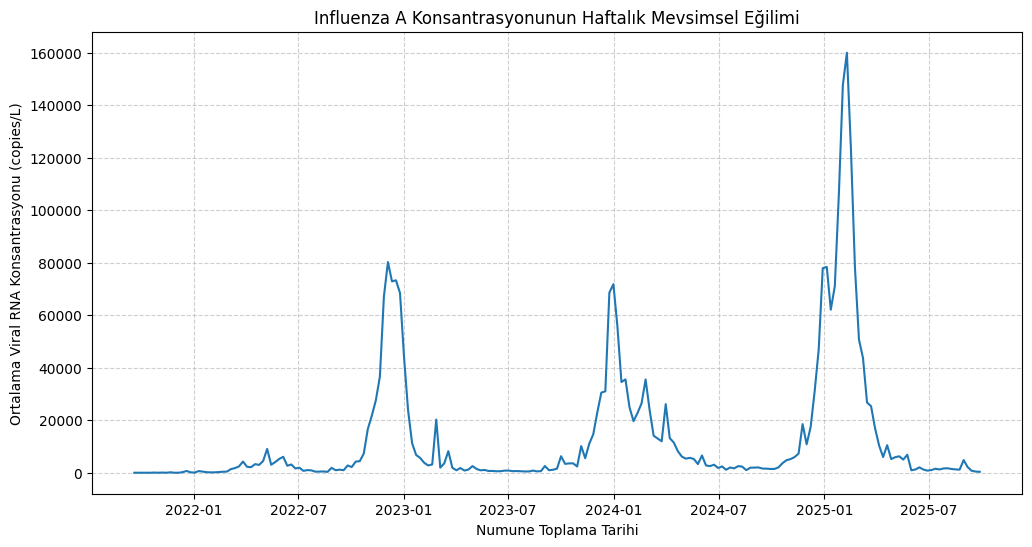

In [6]:
print("\n--- Keşifsel Analizin (EDA) Ana Grafik Çıktıları ---")

# 1. Standart Mevsimsel Eğilim (Zaman)
plt.figure(figsize=(12, 6))
weekly_avg_data = df.dropna(subset=['sample_collect_date', 'pcr_target_avg_conc'])
if not weekly_avg_data.empty:
    weekly_avg = weekly_avg_data.set_index('sample_collect_date')['pcr_target_avg_conc'].resample('W').mean().reset_index()
    sns.lineplot(data=weekly_avg, x='sample_collect_date', y='pcr_target_avg_conc')
plt.title('Influenza A Konsantrasyonunun Haftalık Mevsimsel Eğilimi')
plt.xlabel('Numune Toplama Tarihi')
plt.ylabel('Ortalama Viral RNA Konsantrasyonu (copies/L)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show() 

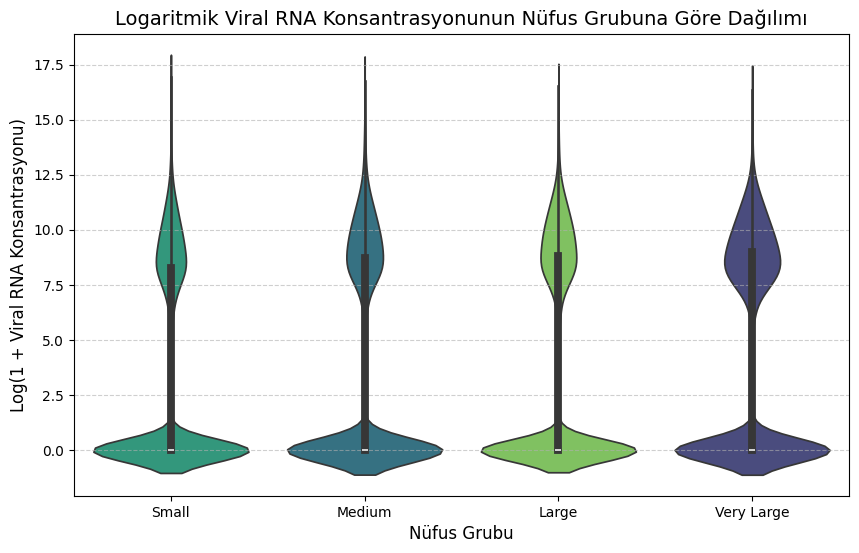

In [7]:
# 2. Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    x=df['population_group'].astype(str), y='log_pcr_target_conc', data=df,
    order=['Small', 'Medium', 'Large', 'Very Large'], palette='viridis',
    hue=df['population_group'].astype(str), legend=False
)
plt.title('Logaritmik Viral RNA Konsantrasyonunun Nüfus Grubuna Göre Dağılımı', fontsize=14)
plt.xlabel('Nüfus Grubu', fontsize=12)
plt.ylabel('Log(1 + Viral RNA Konsantrasyonu)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show() 

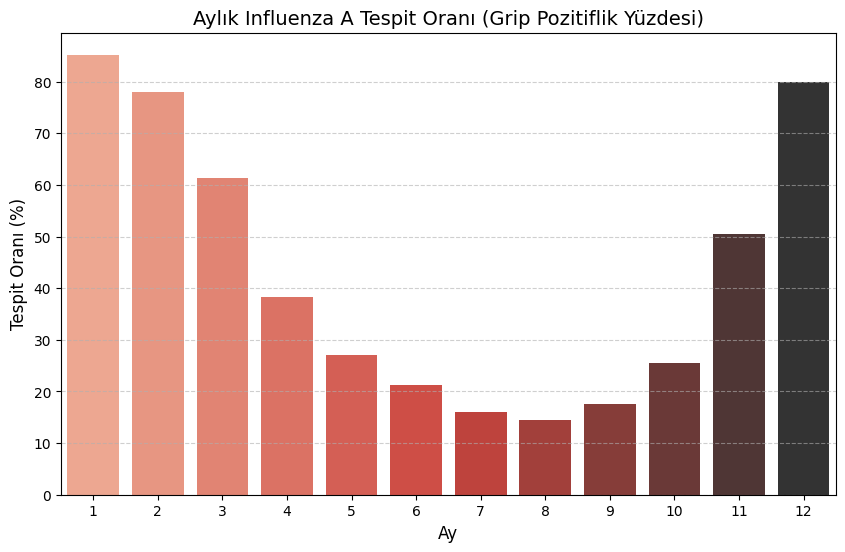

In [8]:
# 3. Aylık Pozitiflik Oranı
monthly_data = df.dropna(subset=['collection_month'])
if not monthly_data.empty:
    monthly_total = monthly_data.groupby('collection_month').size().reset_index(name='total_samples')
    monthly_detected = monthly_data[monthly_data['influenza_a_detected'] == 1].groupby('collection_month').size().reset_index(name='detected_samples')
    monthly_detection_rate = pd.merge(monthly_total, monthly_detected, on='collection_month', how='left')
    monthly_detection_rate['detected_samples'] = monthly_detection_rate['detected_samples'].fillna(0)
    monthly_detection_rate['detection_rate'] = (monthly_detection_rate['detected_samples'] / monthly_total['total_samples']) * 100

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='collection_month', y='detection_rate', data=monthly_detection_rate,
        palette='Reds_d', hue='collection_month', legend=False
    )
    plt.title('Aylık Influenza A Tespit Oranı (Grip Pozitiflik Yüzdesi)', fontsize=14)
    plt.xlabel('Ay', fontsize=12)
    plt.ylabel('Tespit Oranı (%)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show() 

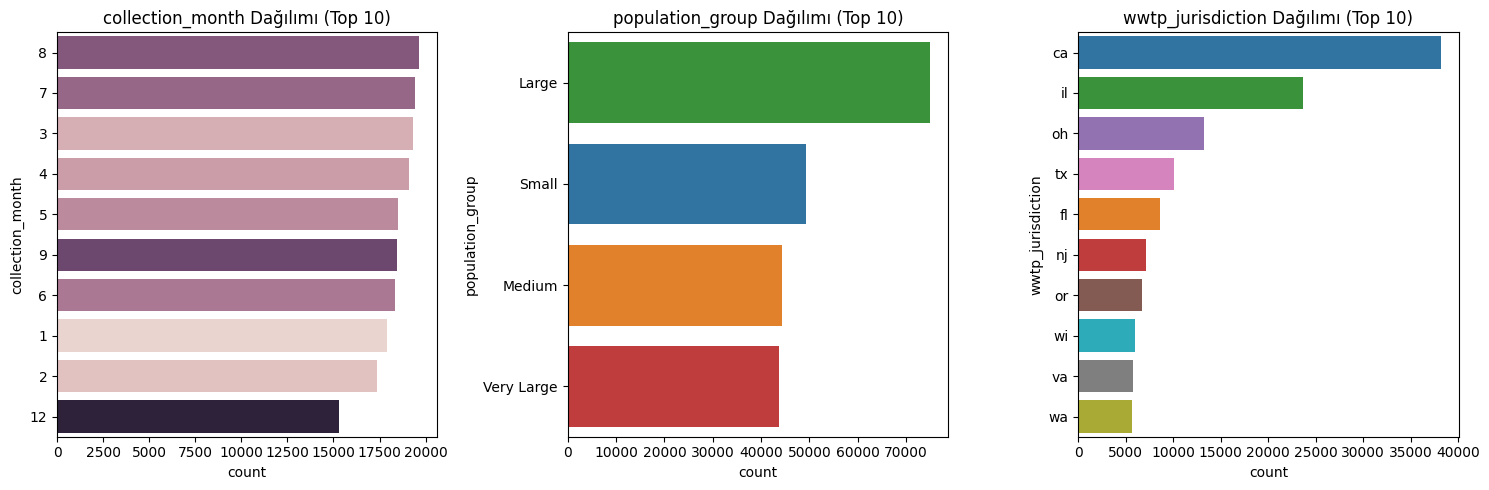

In [9]:
# 4. Kategorik Dağılımlar
categorical_cols_for_plot = ['collection_month', 'population_group', 'wwtp_jurisdiction']
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_cols_for_plot):
    if col in df.columns:
        plt.subplot(1, 3, i + 1)
        plot_data = df[col].dropna()
        if not plot_data.empty:
            top_10_categories = plot_data.value_counts().index[:10]
            plot_df = df[df[col].isin(top_10_categories)]
            sns.countplot(data=plot_df, y=col, order=top_10_categories, hue=col, legend=False)
        plt.title(f'{col} Dağılımı (Top 10)')
plt.tight_layout()
plt.show() 

In [10]:
# --- ÜÇÜNCÜ BÖLÜM: KAYDETME ---
output_file_name = "ulasfeatureseletion.csv"
df.to_csv(output_file_name, index=False)
print(f"\nTemizlenmiş ve (YENİ V2 ÖZELLİKLERİ) içeren veri seti başarıyla kaydedildi: {output_file_name}")


Temizlenmiş ve (YENİ V2 ÖZELLİKLERİ) içeren veri seti başarıyla kaydedildi: ulasfeatureseletion.csv


In [11]:
# --- DÖRDÜNCÜ BÖLÜM: ALGORİTMA SEÇİMİ VE MODEL EĞİTİMİ ---

# 1. ÖZELLİK VE HEDEF BELİRLEME
features = [
    'collection_month', 'collection_week', 'collection_dayofweek',
    'log_population_served', 'log_flow_rate', 'rec_eff_percent',
    'flow_rate_missing', 'flowpop_lin_missing',
    'population_group_encoded', 'log_conc_lag1', 'log_conc_lag2',
    'jurisdiction_target_mean', 'pop_x_flow', 'pop_x_rec_eff'
]

if 'rec_eff_percent' not in df.columns:
    features_to_remove = ['rec_eff_percent', 'pop_x_rec_eff']
    features = [f for f in features if f not in features_to_remove]

df_model = df.dropna(subset=features + ['influenza_a_detected'])
X = df_model[features]
y = df_model['influenza_a_detected']

print(f"\nModelin Kullanacağı Toplam Özellik Sayısı: {X.shape[1]}")
print(f"Model Eğitimi İçin Kullanılan Toplam Satır Sayısı: {X.shape[0]}")

# 2. VERİYİ BÖLME
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. VERİ ÖLÇEKLEME (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Modelin Kullanacağı Toplam Özellik Sayısı: 14
Model Eğitimi İçin Kullanılan Toplam Satır Sayısı: 212401


In [12]:
# --- PCA (TEMEL BİLEŞEN ANALİZİ) ---
print("\n--- PCA ANALİZİNE BAŞLANIYOR ---")
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Orijinal özellik sayısı: {X_train_scaled.shape[1]}")
print(f"PCA sonrası özellik sayısı (%95 varyans): {X_train_pca.shape[1]}")
# --- PCA BÖLÜMÜ SONU ---


--- PCA ANALİZİNE BAŞLANIYOR ---
Orijinal özellik sayısı: 14
PCA sonrası özellik sayısı (%95 varyans): 7



--- MODEL EĞİTİMİ VE KARŞILAŞTIRMASI BAŞLIYOR ---

--- GradientBoosting (Orijinal) Eğitiliyor ---
Model Doğruluğu (Accuracy): 0.8024
ROC AUC Skoru: 0.8699
Average Precision (AP): 0.8519

--- LinearRegression (Orijinal) Eğitiliyor ---
Model Doğruluğu (Accuracy): 0.7758
ROC AUC Skoru: 0.8328
Average Precision (AP): 0.8051

Sınıflandırma Raporu (LinearRegression - Orijinal, Eşik 0.5):
              precision    recall  f1-score   support

Grip Yok (0)       0.78      0.86      0.82     24632
Grip Var (1)       0.77      0.66      0.71     17849

    accuracy                           0.78     42481
   macro avg       0.78      0.76      0.76     42481
weighted avg       0.78      0.78      0.77     42481


Karmaşıklık Matrisi (LinearRegression - Orijinal, Eşik 0.5):
[[21215  3417]
 [ 6107 11742]]


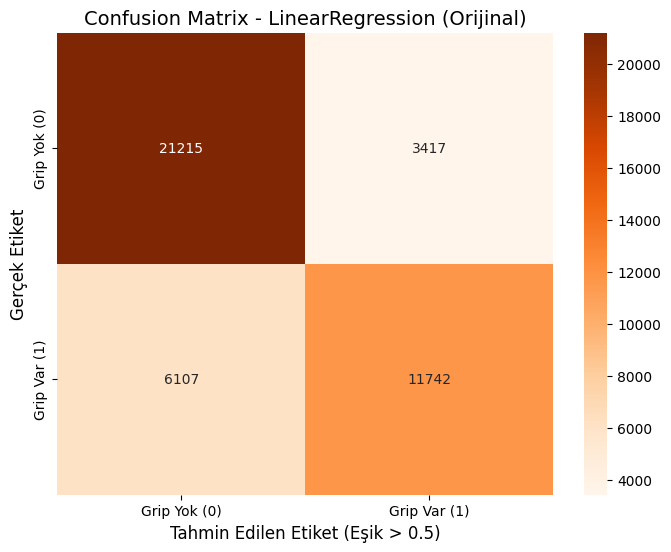


--- GradientBoosting (PCA) Eğitiliyor ---
Model Doğruluğu (Accuracy): 0.7925
ROC AUC Skoru: 0.8568
Average Precision (AP): 0.8345

--- LinearRegression (PCA) Eğitiliyor ---
Model Doğruluğu (Accuracy): 0.7756
ROC AUC Skoru: 0.8321
Average Precision (AP): 0.8044

Tüm modellerin sonuçları:
                         Model  Accuracy   ROC_AUC  Average_Precision
0  GradientBoosting (Orijinal)  0.802359  0.869927           0.851856
1  LinearRegression (Orijinal)  0.775806  0.832784           0.805144
2       GradientBoosting (PCA)  0.792543  0.856768           0.834516
3       LinearRegression (PCA)  0.775641  0.832114           0.804359


In [13]:
# 4. MODELLERİ TANIMLAMA VE EĞİTME
print("\n--- MODEL EĞİTİMİ VE KARŞILAŞTIRMASI BAŞLIYOR ---")

# Modelleri tanımla (4 senaryo)
models = {
    'GradientBoosting (Orijinal)': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LinearRegression (Orijinal)': LinearRegression(n_jobs=-1),
    'GradientBoosting (PCA)': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LinearRegression (PCA)': LinearRegression(n_jobs=-1)
}

# Veri setlerini tanımla
data_sets = {
    'GradientBoosting (Orijinal)': (X_train_scaled, X_test_scaled),
    'LinearRegression (Orijinal)': (X_train_scaled, X_test_scaled),
    'GradientBoosting (PCA)': (X_train_pca, X_test_pca),
    'LinearRegression (PCA)': (X_train_pca, X_test_pca)
}

# Sonuçları saklamak için
results = []
roc_curves = {}
pr_curves = {}

# Modelleri eğit ve değerlendir
for model_name, model in models.items():
    print(f"\n--- {model_name} Eğitiliyor ---")
    X_train_data, X_test_data = data_sets[model_name]
    
    # Model eğitimi
    model.fit(X_train_data, y_train)
    
    # Tahminler
    y_pred_continuous = None
    y_pred_binary = None
    y_pred_proba_positive = None

    if "LinearRegression" in model_name:
        y_pred_continuous = model.predict(X_test_data)
        y_pred_binary = (y_pred_continuous > 0.5).astype(int)
        y_pred_proba_positive = np.clip(y_pred_continuous, 0, 1)
    else:
        # GradientBoosting (predict_proba desteği var)
        y_pred_binary = model.predict(X_test_data)
        y_pred_proba_positive = model.predict_proba(X_test_data)[:, 1]
    
    # Metrikler
    accuracy = accuracy_score(y_test, y_pred_binary)
    avg_precision = average_precision_score(y_test, y_pred_proba_positive)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba_positive)
    roc_auc = auc(fpr, tpr)
    
    print(f"Model Doğruluğu (Accuracy): {accuracy:.4f}")
    print(f"ROC AUC Skoru: {roc_auc:.4f}")
    print(f"Average Precision (AP): {avg_precision:.4f}")
    
    # Sonuçları kaydet
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'ROC_AUC': roc_auc,
        'Average_Precision': avg_precision
    })
    
    # Sadece Orijinal özellikli modellerin eğrilerini sakla
    if 'Orijinal' in model_name:
        roc_curves[model_name] = (fpr, tpr, roc_auc)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_positive)
        pr_curves[model_name] = (recall, precision, avg_precision)

        # İstenen LinearRegression için Rapor ve CM yazdır
        if 'LinearRegression (Orijinal)' in model_name:
            print("\nSınıflandırma Raporu (LinearRegression - Orijinal, Eşik 0.5):")
            print(classification_report(y_test, y_pred_binary, target_names=['Grip Yok (0)', 'Grip Var (1)']))
            
            conf_matrix_lr = confusion_matrix(y_test, y_pred_binary)
            print("\nKarmaşıklık Matrisi (LinearRegression - Orijinal, Eşik 0.5):")
            print(conf_matrix_lr)
            
            plt.figure(figsize=(8, 6))
            sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Oranges',
                        xticklabels=['Grip Yok (0)', 'Grip Var (1)'],
                        yticklabels=['Grip Yok (0)', 'Grip Var (1)'])
            plt.title('Confusion Matrix - LinearRegression (Orijinal)', fontsize=14)
            plt.xlabel('Tahmin Edilen Etiket (Eşik > 0.5)', fontsize=12)
            plt.ylabel('Gerçek Etiket', fontsize=12)
            plt.show() # GÖSTER

results_df = pd.DataFrame(results)
print("\nTüm modellerin sonuçları:")
print(results_df)


--- MODEL KARŞILAŞTIRMA GRAFİKLERİ OLUŞTURULUYOR ---


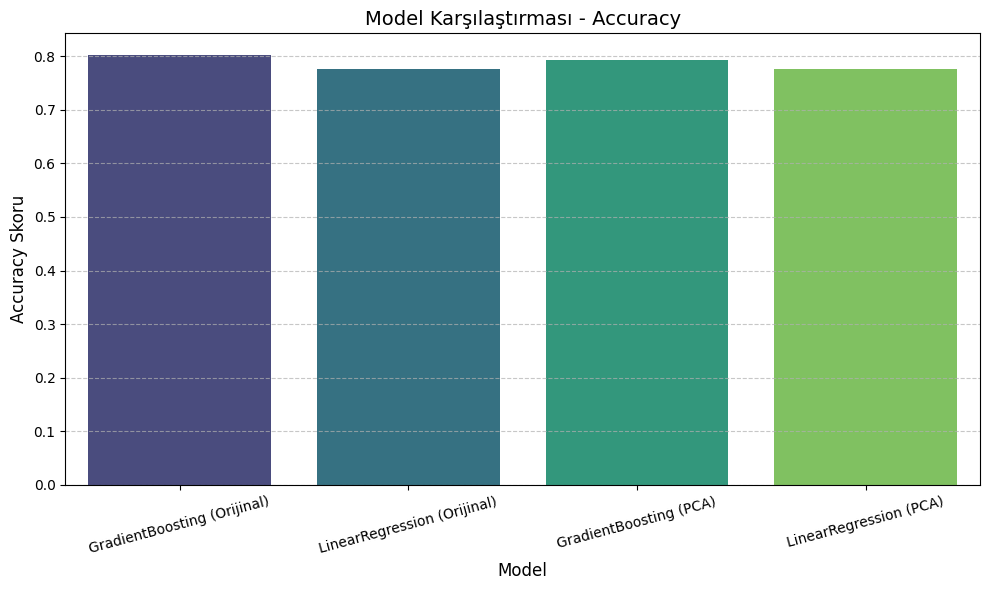

In [14]:
print("\n--- MODEL KARŞILAŞTIRMA GRAFİKLERİ OLUŞTURULUYOR ---")

# 1. Accuracy Karşılaştırması
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis', hue='Model', legend=False)
plt.title('Model Karşılaştırması - Accuracy', fontsize=14)
plt.ylabel('Accuracy Skoru', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() 

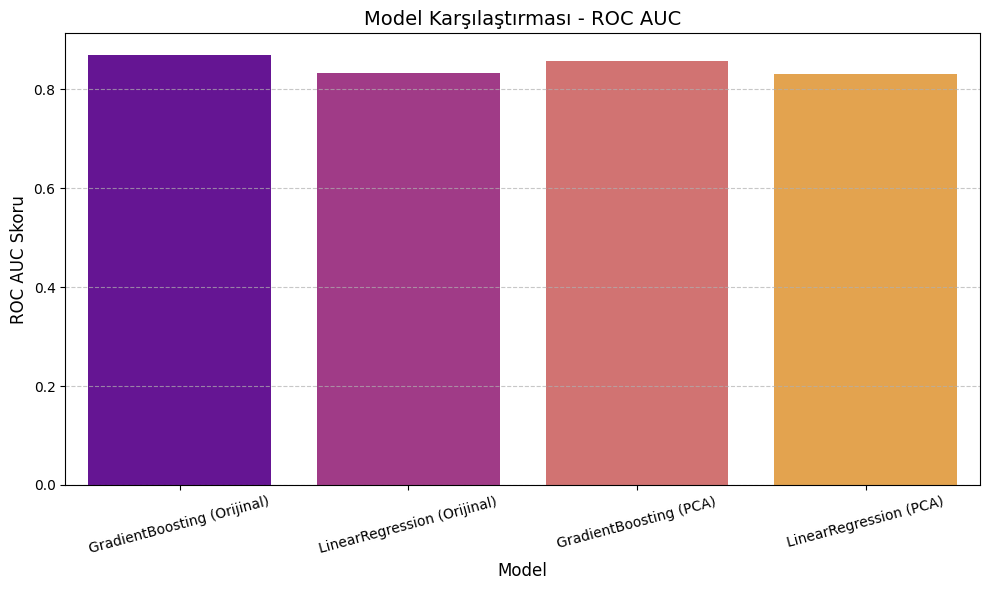

In [15]:
# 2. ROC AUC Karşılaştırması
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='ROC_AUC', data=results_df, palette='plasma', hue='Model', legend=False)
plt.title('Model Karşılaştırması - ROC AUC', fontsize=14)
plt.ylabel('ROC AUC Skoru', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() 

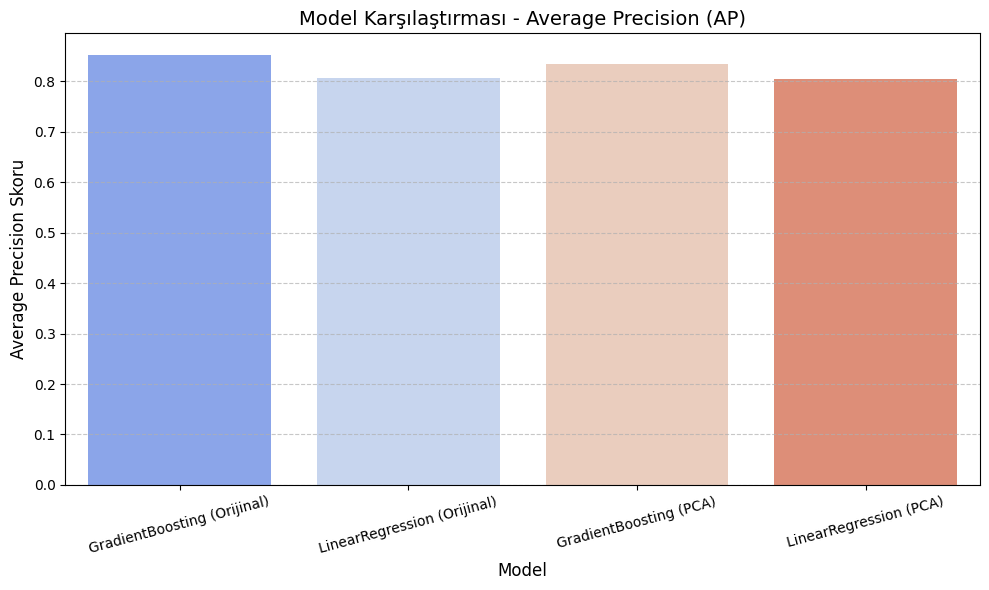

In [16]:
# 3. Average Precision Karşılaştırması
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Average_Precision', data=results_df, palette='coolwarm', hue='Model', legend=False)
plt.title('Model Karşılaştırması - Average Precision (AP)', fontsize=14)
plt.ylabel('Average Precision Skoru', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show() 

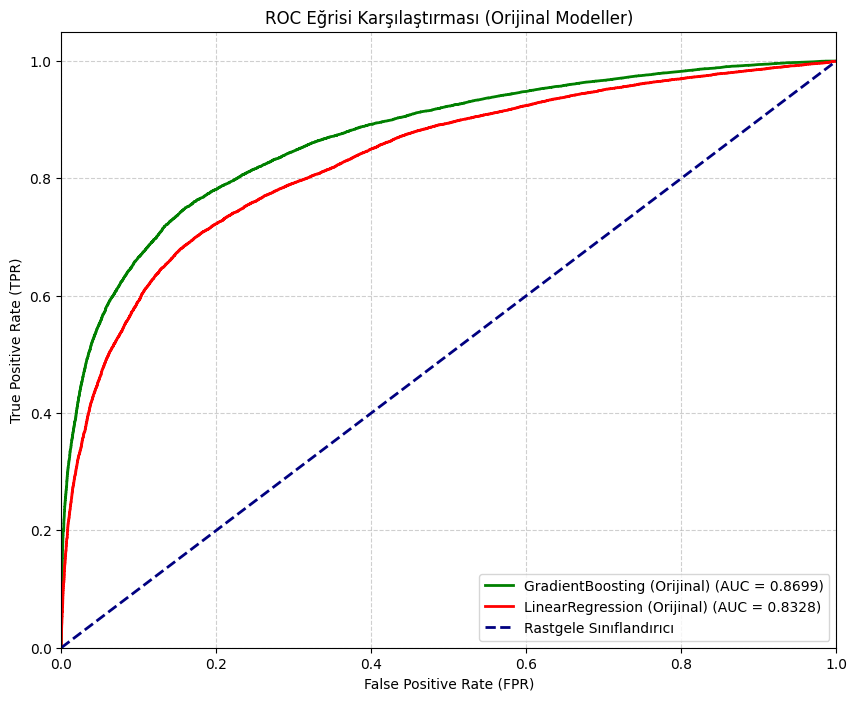

In [17]:
# 4. Orijinal Modeller için ROC Eğrileri
plt.figure(figsize=(10, 8))
# Renk paleti 2 model için güncellendi
colors = {'LinearRegression': 'red', 'GradientBoosting': 'green'}
for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
    key = model_name.split(' ')[0]
    plt.plot(fpr, tpr, lw=2, color=colors[key], label=f'{model_name} (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Rastgele Sınıflandırıcı')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Eğrisi Karşılaştırması (Orijinal Modeller)')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show() 

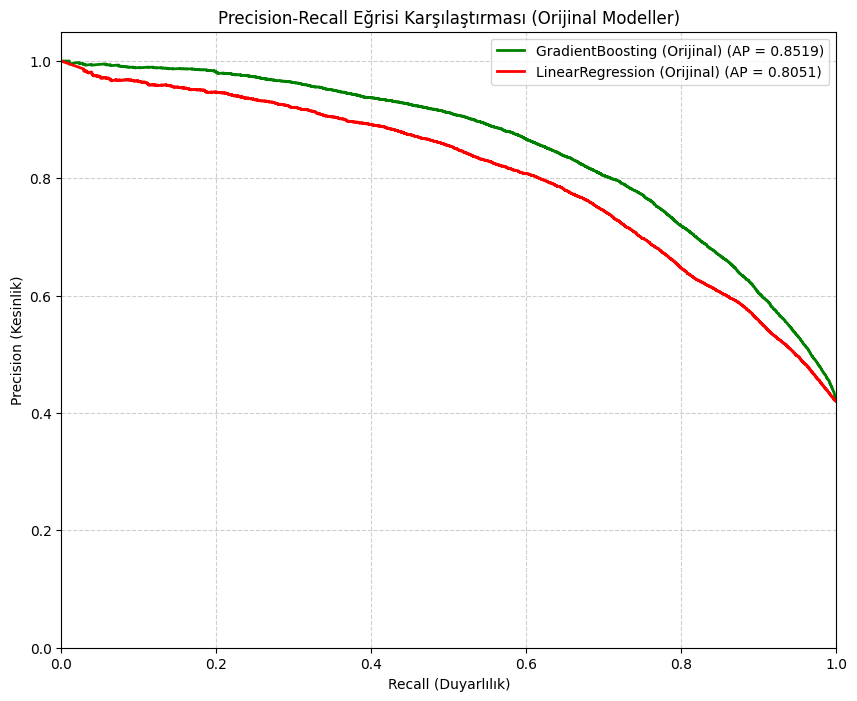

In [18]:
# 5. Orijinal Modeller için PR Eğrileri
plt.figure(figsize=(10, 8))
for model_name, (recall, precision, avg_precision) in pr_curves.items():
    key = model_name.split(' ')[0]
    plt.plot(recall, precision, lw=2, color=colors[key], label=f'{model_name} (AP = {avg_precision:.4f})')
plt.xlabel('Recall (Duyarlılık)')
plt.ylabel('Precision (Kesinlik)')
plt.title('Precision-Recall Eğrisi Karşılaştırması (Orijinal Modeller)')
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show() 

In [19]:
# --- RandomForest'a ait özellik önemi grafiği kaldırıldı ---

print("\n!!! Veri Bilimi Projesi Tamamlandı (Sadece GB ve Lineer Regresyon)")
print("karşılaştırma grafikleri ve analizler oluşturuldu.")


!!! Veri Bilimi Projesi Tamamlandı (Sadece GB ve Lineer Regresyon)
karşılaştırma grafikleri ve analizler oluşturuldu.
